# Test for Verifying Filtering & Data Imputation Working Logic

In [58]:
import sys
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np

sys.path.append("../file_loader")
sys.path.append("../preprocessing-block")

import ecg_file_loader
from ecg_file_loader import ECGFileLoader

import rpeaks_finder
from rpeaks_finder import *

import ectopic_beats_filtering
from ectopic_beats_filtering import *

reload(ecg_file_loader)
reload(rpeaks_finder)
reload(ectopic_beats_filtering)

<module 'ectopic_beats_filtering' from '/Users/ashleyandrea/Documents/StartUps/seizury/seizure-block-codes/check_codes/../preprocessing-block/ectopic_beats_filtering.py'>

In [59]:
loader = ECGFileLoader(use_s3=False)

In [3]:
processed_data = process_all_patients_rpeaks(loader, ['sub-036'])

INFO:rpeaks_finder:Processing R-peaks detection for 1 patients: ['sub-036']
INFO:rpeaks_finder:Loading data for patient sub-036
INFO:ecg_file_loader:Processing sub-036 run 01
INFO:rpeaks_finder:Processing sub-036 run 01
INFO:rpeaks_finder:ECG signal shape: (18523136,), sampling rate: 256.0 Hz
INFO:rpeaks_finder:Successfully processed sub-036 run 01: 85145 R-peaks detected
INFO:rpeaks_finder:Completed R-peaks detection processing for 1 runs
INFO:rpeaks_finder:Completed processing for patient sub-036: 1 runs


In [4]:
print(processed_data)

{'sub-036': [{'patient_id': 'sub-036', 'run_number': '01', 'seizure_events': [{'onset_time': 40971.0, 'duration': 38.0, 'type': 'sz_foc_ia_m_hyperkinetic', 'lateralization': 'left', 'localization': 'front', 'vigilance': 'asleep'}, {'onset_time': 43485.0, 'duration': 41.0, 'type': 'sz_foc_ia_m_hyperkinetic', 'lateralization': 'left', 'localization': 'front', 'vigilance': 'asleep'}, {'onset_time': 46456.0, 'duration': 53.0, 'type': 'sz_foc_ia_m_hyperkinetic', 'lateralization': 'left', 'localization': 'front', 'vigilance': 'asleep'}], 'annotations':      onset  duration                 eventType lateralization localization  \
0  27003.0     569.0                      impd            NaN          NaN   
1  40971.0      38.0  sz_foc_ia_m_hyperkinetic           left        front   
2  43485.0      41.0  sz_foc_ia_m_hyperkinetic           left        front   
3  46456.0      53.0  sz_foc_ia_m_hyperkinetic           left        front   
4  55840.0      33.0                      impd           

In [5]:
len(processed_data['sub-036'][0]['rr_intervals_ms']), len(processed_data['sub-036'][0]['rpeaks_times'])

(85144, 85145)

Patient's dimensions of RR intervals and timestamps are *n* and *n+1*, which is correct! Below we print some examples of peaks times with relative intervals.

In [26]:
print(f"First peak time: {processed_data['sub-036'][0]['rpeaks_times'][810]}, second peak time: {processed_data['sub-036'][0]['rpeaks_times'][811]} -> RR interval: {processed_data['sub-036'][0]['rr_intervals_ms'][810]*1e-3}")
print(f"Second peak time: {processed_data['sub-036'][0]['rpeaks_times'][811]}, third peak time: {processed_data['sub-036'][0]['rpeaks_times'][812]} -> RR interval: {processed_data['sub-036'][0]['rr_intervals_ms'][811]*1e-3}")
print(f"Third peak time: {processed_data['sub-036'][0]['rpeaks_times'][812]}, fourth peak time: {processed_data['sub-036'][0]['rpeaks_times'][813]} -> RR interval: {processed_data['sub-036'][0]['rr_intervals_ms'][812]*1e-3}")
print(f"Fourth peak time: {processed_data['sub-036'][0]['rpeaks_times'][813]}, fifth peak time: {processed_data['sub-036'][0]['rpeaks_times'][814]} -> RR interval: {processed_data['sub-036'][0]['rr_intervals_ms'][813]*1e-3}")

First peak time: 636.21484375, second peak time: 637.55078125 -> RR interval: 1.3359375
Second peak time: 637.55078125, third peak time: 637.83984375 -> RR interval: 0.2890625
Third peak time: 637.83984375, fourth peak time: 638.2421875 -> RR interval: 0.40234375
Fourth peak time: 638.2421875, fifth peak time: 640.390625 -> RR interval: 2.1484375


As we can see, there are two unduly long intervals and a short one. Let's check them after ectopic beats filtering!

## Eptopic Beats Filtering

In [13]:
filtered_rr, filtered_ts = filter_ectopic_beats(processed_data['sub-036'][0]['rr_intervals_ms'], processed_data['sub-036'][0]['rpeaks_times'], 0.3, 1.3)
len(filtered_rr), len(filtered_ts)  # Should be len(filtered_ts) == len(filtered_rr) + 1

--- Starting Ectopic Beat Filtering ---
Found 806 RR intervals > 1.3s. Deleting them to create gaps.
Found short RR interval (0.277s) at index 84334. Analyzing merge options...
  > Right merge successful. New RR: 0.598s.
Found short RR interval (0.285s) at index 84326. Analyzing merge options...
  > Left merge successful. New RR: 0.727s.
Found short RR interval (0.289s) at index 84320. Analyzing merge options...
  > Right merge successful. New RR: 0.641s.
Found short RR interval (0.258s) at index 84317. Analyzing merge options...
  > No merge met all conditions. Deleting the single short RR interval as an artifact.
Found short RR interval (0.293s) at index 84289. Analyzing merge options...
  > No merge met all conditions. Deleting the single short RR interval as an artifact.
Found short RR interval (0.297s) at index 84278. Analyzing merge options...
  > Right merge successful. New RR: 0.602s.
Found short RR interval (0.289s) at index 84276. Analyzing merge options...
  > Left merge suc

(83814, 83815)

Above we can analize the whole procedure of deleting or merging and adapting timestamps to preseve time coherence. Again, the patient's dimensions of filtered RR intervals and timestamps are *n* and *n+1*, which means the algorithm works as expected!!

Below are some prints for a safety check.

In [24]:
print(f"First filtered peak time: {filtered_ts[800]}, second filtered peak time: {filtered_ts[801]} -> filtered RR interval: {filtered_rr[800]}")
print(f"Second filtered peak time: {filtered_ts[801]}, third filtered peak time: {filtered_ts[802]} -> filtered RR interval: {filtered_rr[801]}")
print(f"Third filtered peak time: {filtered_ts[802]}, fourth filtered peak time: {filtered_ts[803]} -> filtered RR interval: {filtered_rr[802]}")
print(f"Fourth filtered peak time: {filtered_ts[803]}, fifth filtered peak time: {filtered_ts[804]} -> filtered RR interval: {filtered_rr[803]}")

First filtered peak time: 635.66015625, second filtered peak time: 637.83984375 -> filtered RR interval: 0.5546875
Second filtered peak time: 637.83984375, third filtered peak time: 644.21484375 -> filtered RR interval: 0.40234375
Third filtered peak time: 644.21484375, fourth filtered peak time: 644.5703125 -> filtered RR interval: 0.35546875
Fourth filtered peak time: 644.5703125, fifth filtered peak time: 644.8828125 -> filtered RR interval: 0.3125


As we can see, at approximately the time considered earlier, there are no more unduly long RR intervals, neither too short ones!! The gaps created between two timestamps are due to long peaks deletion and will be filled with imputed peaks in the following step. 

## Filling Gaps with Data Imputation

In [27]:
imputed_rr, imputed_ts = impute_gaps(filtered_rr, filtered_ts, 0.3, 1.3)
len(imputed_rr), len(imputed_ts)  # Should be len(imputed_ts) == len(imputed_rr) + 1


--- Starting Gap Imputation ---
Found a 2.68s gap. The RR interval at index 390 will be replaced.
  > Replacing 1 large RR with 3 new beats.
Found a 2.30s gap. The RR interval at index 565 will be replaced.
  > Replacing 1 large RR with 3 new beats.
Found a 1.84s gap. The RR interval at index 773 will be replaced.
  > Replacing 1 large RR with 3 new beats.
Found a 2.54s gap. The RR interval at index 783 will be replaced.
  > Replacing 1 large RR with 4 new beats.
Found a 3.81s gap. The RR interval at index 791 will be replaced.
  > Replacing 1 large RR with 5 new beats.
Found a 2.18s gap. The RR interval at index 813 will be replaced.
  > Replacing 1 large RR with 3 new beats.
Found a 6.38s gap. The RR interval at index 816 will be replaced.
  > Replacing 1 large RR with 10 new beats.
Found a 5.16s gap. The RR interval at index 834 will be replaced.
  > Replacing 1 large RR with 8 new beats.
Found a 5.63s gap. The RR interval at index 1947 will be replaced.
  > Replacing 1 large RR wi

(85400, 85401)

Once again, the dimensions are correct!

## Complete Pipeline

We can also run the whole pipeline for simplicity.

In [28]:
processed_rr = process_dvc_for_session(processed_data['sub-036'][0], min_rr_s=0.3, max_rr_s=1.3)


--------------------------------------------------
Processing session 01 for patient sub-036
--------------------------------------------------
Initial state: 85144 RRs, 85145 timestamps.
--- Starting Ectopic Beat Filtering ---
Found 806 RR intervals > 1.3s. Deleting them to create gaps.
Found short RR interval (0.277s) at index 84334. Analyzing merge options...
  > Right merge successful. New RR: 0.598s.
Found short RR interval (0.285s) at index 84326. Analyzing merge options...
  > Left merge successful. New RR: 0.727s.
Found short RR interval (0.289s) at index 84320. Analyzing merge options...
  > Right merge successful. New RR: 0.641s.
Found short RR interval (0.258s) at index 84317. Analyzing merge options...
  > No merge met all conditions. Deleting the single short RR interval as an artifact.
Found short RR interval (0.293s) at index 84289. Analyzing merge options...
  > No merge met all conditions. Deleting the single short RR interval as an artifact.
Found short RR interval (

The final verification controls dimesions are valid, and they are!

In [29]:
new_rr_intervals_ms = processed_rr['dvc_rr_intervals_ms']
new_rpeak_times_s = processed_rr['dvc_rpeak_times_s']

In [30]:
len(new_rr_intervals_ms), len(new_rpeak_times_s)  # Should be len(new_rpeak_times_s) == len(new_rr_intervals_ms) + 1

(85397, 85398)

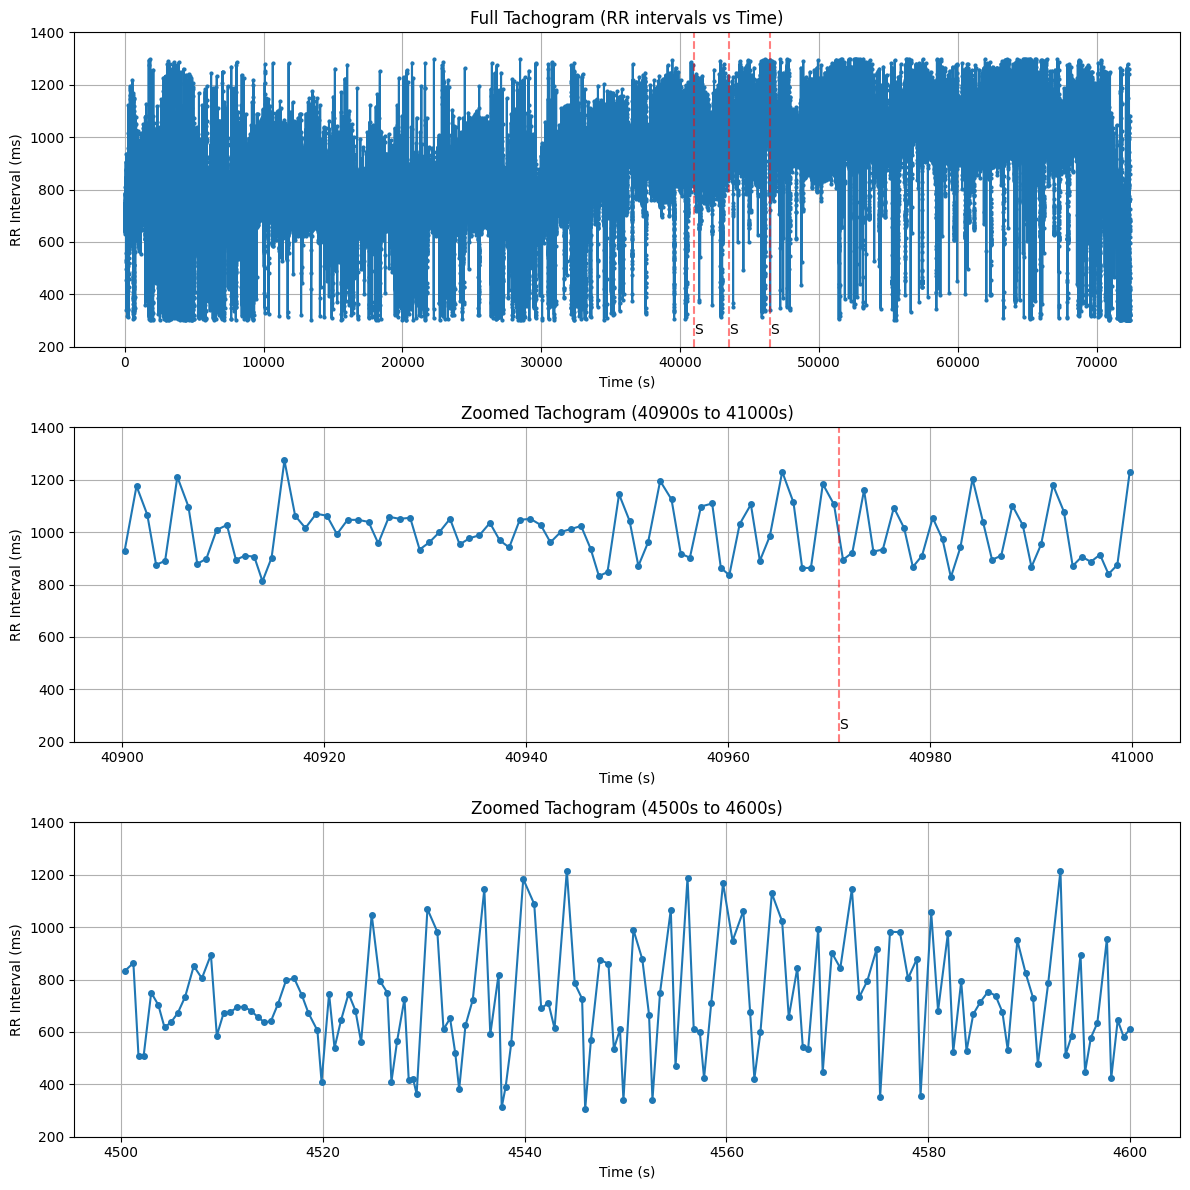

In [45]:
time_axis = new_rpeak_times_s[1:]  # Use timestamps from second peak onwards

# Get seizure events from processed data
seizure_events = processed_data['sub-036'][0]['seizure_events']

# First plot: Full tachogram with fixed y-axis limits and seizure markers
plt.figure(figsize=(12, 12))
plt.subplot(311)
plt.plot(time_axis, new_rr_intervals_ms, marker='o', markersize=2, linestyle='-')
plt.ylim(200, 1400)  

# Add seizure onset markers
for seizure in seizure_events:
    onset_time = seizure['onset_time']
    plt.axvline(x=onset_time, color='r', linestyle='--', alpha=0.5)
    plt.text(onset_time, 250, 'S', rotation=0)

plt.title("Full Tachogram (RR intervals vs Time)")
plt.xlabel("Time (s)")
plt.ylabel("RR Interval (ms)")
plt.grid(True)

# Second plot: Zoomed section with start and end times
plt.subplot(312)
zoom_start = 40900  
zoom_end = 41000    
zoom_mask = (time_axis >= zoom_start) & (time_axis <= zoom_end)
plt.plot(time_axis[zoom_mask], new_rr_intervals_ms[zoom_mask], 
         marker='o', markersize=4, linestyle='-')
plt.ylim(200, 1400)

# Add seizure onset markers in zoom window
for seizure in seizure_events:
    onset_time = seizure['onset_time']
    if zoom_start <= onset_time <= zoom_end:
        plt.axvline(x=onset_time, color='r', linestyle='--', alpha=0.5)
        plt.text(onset_time, 250, 'S', rotation=0)

plt.title(f"Zoomed Tachogram ({zoom_start}s to {zoom_end}s)")
plt.xlabel("Time (s)")
plt.ylabel("RR Interval (ms)")
plt.grid(True)

# Third plot: Zoomed section with start and end times
plt.subplot(313)
zoom_start = 4500  
zoom_end = 4600    
zoom_mask = (time_axis >= zoom_start) & (time_axis <= zoom_end)
plt.plot(time_axis[zoom_mask], new_rr_intervals_ms[zoom_mask], 
         marker='o', markersize=4, linestyle='-')
plt.ylim(200, 1400)

# Add seizure onset markers in zoom window
for seizure in seizure_events:
    onset_time = seizure['onset_time']
    if zoom_start <= onset_time <= zoom_end:
        plt.axvline(x=onset_time, color='r', linestyle='--', alpha=0.5)
        plt.text(onset_time, 250, 'S', rotation=0)

plt.title(f"Zoomed Tachogram ({zoom_start}s to {zoom_end}s)")
plt.xlabel("Time (s)")
plt.ylabel("RR Interval (ms)")
plt.grid(True)

plt.tight_layout()
plt.show()

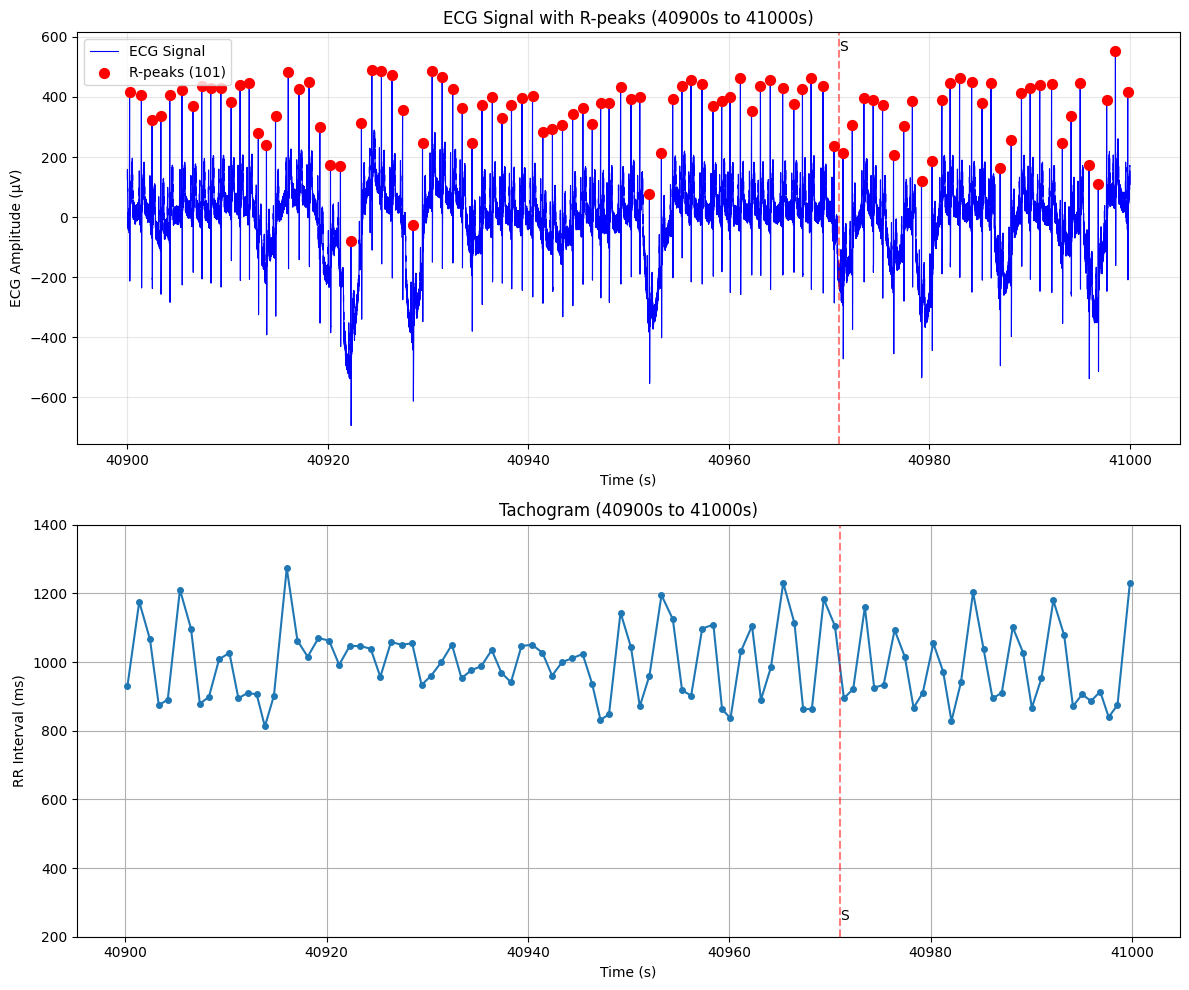

Statistics for window 40900s to 41000s:
  R-peaks detected: 101
  Average RR interval: 995.7 ms
  Average heart rate: 60.3 bpm


In [48]:
# Get ECG signal data
ecg_signal = processed_data['sub-036'][0]['ecg_signal']
rpeaks = processed_data['sub-036'][0]['rpeaks']
sampling_rate = processed_data['sub-036'][0]['sampling_rate']
seizure_events = processed_data['sub-036'][0]['seizure_events']

# Use the same zoom window as subplot 2
zoom_start = 40900  
zoom_end = 41000

# Calculate sample indices for the time window
start_sample = int(zoom_start * sampling_rate)
end_sample = int(zoom_end * sampling_rate)
end_sample = min(end_sample, len(ecg_signal))

# Extract signal segment
time_axis_ecg = np.arange(start_sample, end_sample) / sampling_rate
ecg_segment = ecg_signal[start_sample:end_sample]

# Filter R-peaks within the time window
rpeaks_in_window = rpeaks[(rpeaks >= start_sample) & (rpeaks < end_sample)]
rpeaks_times = rpeaks_in_window / sampling_rate

# Create comparison plot
plt.figure(figsize=(12, 10))

# First subplot: Tachogram (same as your subplot 2)
plt.subplot(212)
time_axis = new_rpeak_times_s[1:]
zoom_mask = (time_axis >= zoom_start) & (time_axis <= zoom_end)
plt.plot(time_axis[zoom_mask], new_rr_intervals_ms[zoom_mask], 
         marker='o', markersize=4, linestyle='-')
plt.ylim(200, 1400)

# Add seizure onset markers
for seizure in seizure_events:
    onset_time = seizure['onset_time']
    if zoom_start <= onset_time <= zoom_end:
        plt.axvline(x=onset_time, color='r', linestyle='--', alpha=0.5)
        plt.text(onset_time, 250, 'S', rotation=0)

plt.title(f"Tachogram ({zoom_start}s to {zoom_end}s)")
plt.xlabel("Time (s)")
plt.ylabel("RR Interval (ms)")
plt.grid(True)

# Second subplot: ECG with R-peaks
plt.subplot(211)
plt.plot(time_axis_ecg, ecg_segment * 1e6, 'b-', linewidth=0.8, label='ECG Signal')

# Plot R-peaks
if len(rpeaks_in_window) > 0:
    rpeak_values = ecg_signal[rpeaks_in_window] * 1e6
    plt.scatter(rpeaks_times, rpeak_values, color='red', s=50, zorder=5, 
                label=f'R-peaks ({len(rpeaks_in_window)})')

# Add seizure markers
for seizure in seizure_events:
    onset_time = seizure['onset_time']
    if zoom_start <= onset_time <= zoom_end:
        plt.axvline(x=onset_time, color='r', linestyle='--', alpha=0.5)
        plt.text(onset_time, plt.ylim()[1] * 0.9, 'S', rotation=0)

plt.xlabel('Time (s)')
plt.ylabel('ECG Amplitude (μV)')
plt.title(f'ECG Signal with R-peaks ({zoom_start}s to {zoom_end}s)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print(f"Statistics for window {zoom_start}s to {zoom_end}s:")
print(f"  R-peaks detected: {len(rpeaks_in_window)}")
if len(rpeaks_in_window) > 1:
    window_rr = np.diff(rpeaks_in_window) / sampling_rate * 1000
    window_hr = 60000 / np.mean(window_rr)
    print(f"  Average RR interval: {np.mean(window_rr):.1f} ms")
    print(f"  Average heart rate: {window_hr:.1f} bpm")

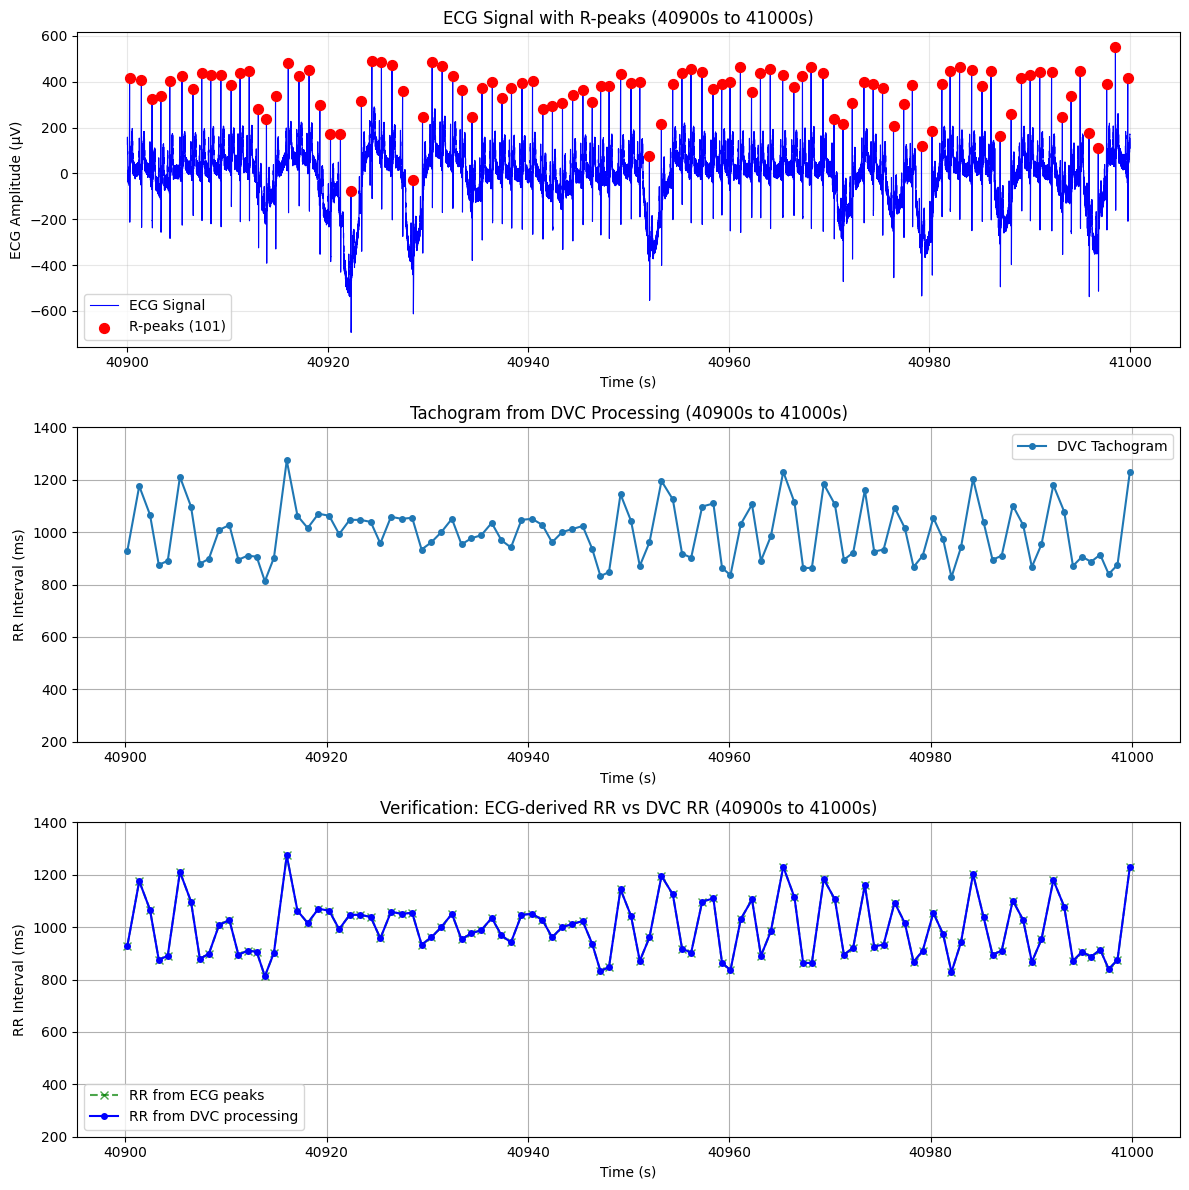


Verification Statistics for window 40900s to 41000s:
  Number of R-peaks in ECG: 101
  Number of RR intervals from ECG: 101
  Number of RR intervals in DVC tachogram: 101

  ECG-derived RR intervals:
    Mean: 995.01 ms
    Std: 106.64 ms

  DVC tachogram RR intervals:
    Mean: 995.01 ms
    Std: 106.64 ms

  Difference in count: 0


In [55]:
# Verification: Compare RR intervals from different sources
time_axis = new_rpeak_times_s[1:]

# Get ECG data
ecg_signal = processed_data['sub-036'][0]['ecg_signal']
rpeaks = processed_data['sub-036'][0]['rpeaks']
sampling_rate = processed_data['sub-036'][0]['sampling_rate']
seizure_events = processed_data['sub-036'][0]['seizure_events']

# Define zoom window
zoom_start = 40900  
zoom_end = 41000

# Calculate RR intervals directly from ECG peaks (in samples)
rr_from_ecg_samples = np.diff(rpeaks)
rr_from_ecg_ms = (rr_from_ecg_samples / sampling_rate) * 1000  # Convert to ms
rr_time_axis = (rpeaks[1:] / sampling_rate)  # Time axis for ECG-based RR

# Create comparison figure
plt.figure(figsize=(12, 12))

# Subplot 1: ECG Signal with R-peaks
plt.subplot(311)
start_sample = int(zoom_start * sampling_rate)
end_sample = int(zoom_end * sampling_rate)
time_axis_ecg = np.arange(start_sample, end_sample) / sampling_rate
ecg_segment = ecg_signal[start_sample:end_sample]
rpeaks_in_window = rpeaks[(rpeaks >= start_sample) & (rpeaks < end_sample)]
rpeaks_times = rpeaks_in_window / sampling_rate

plt.plot(time_axis_ecg, ecg_segment * 1e6, 'b-', linewidth=0.8, label='ECG Signal')
if len(rpeaks_in_window) > 0:
    rpeak_values = ecg_signal[rpeaks_in_window] * 1e6
    plt.scatter(rpeaks_times, rpeak_values, color='red', s=50, zorder=5, 
                label=f'R-peaks ({len(rpeaks_in_window)})')
plt.xlabel('Time (s)')
plt.ylabel('ECG Amplitude (μV)')
plt.title(f'ECG Signal with R-peaks ({zoom_start}s to {zoom_end}s)')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Tachogram from DVC processing
plt.subplot(312)
zoom_mask = (time_axis >= zoom_start) & (time_axis <= zoom_end)
plt.plot(time_axis[zoom_mask], new_rr_intervals_ms[zoom_mask], 
         marker='o', markersize=4, linestyle='-', label='DVC Tachogram')
plt.ylim(200, 1400)
plt.title(f"Tachogram from DVC Processing ({zoom_start}s to {zoom_end}s)")
plt.xlabel("Time (s)")
plt.ylabel("RR Interval (ms)")
plt.legend()
plt.grid(True)

# Subplot 3: Overlay comparison - RR from ECG vs DVC Tachogram
plt.subplot(313)
rr_ecg_mask = (rr_time_axis >= zoom_start) & (rr_time_axis <= zoom_end)
plt.plot(rr_time_axis[rr_ecg_mask], rr_from_ecg_ms[rr_ecg_mask], 
         marker='x', markersize=6, linestyle='--', color='green', 
         label='RR from ECG peaks', alpha=0.7)
plt.plot(time_axis[zoom_mask], new_rr_intervals_ms[zoom_mask], 
         marker='o', markersize=4, linestyle='-', color='blue',
         label='RR from DVC processing')
plt.ylim(200, 1400)
plt.title(f"Verification: ECG-derived RR vs DVC RR ({zoom_start}s to {zoom_end}s)")
plt.xlabel("Time (s)")
plt.ylabel("RR Interval (ms)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print numerical comparison
print(f"\nVerification Statistics for window {zoom_start}s to {zoom_end}s:")
print(f"  Number of R-peaks in ECG: {len(rpeaks_in_window)}")
print(f"  Number of RR intervals from ECG: {len(rr_from_ecg_ms[rr_ecg_mask])}")
print(f"  Number of RR intervals in DVC tachogram: {len(new_rr_intervals_ms[zoom_mask])}")

if len(rr_from_ecg_ms[rr_ecg_mask]) > 0:
    print(f"\n  ECG-derived RR intervals:")
    print(f"    Mean: {np.mean(rr_from_ecg_ms[rr_ecg_mask]):.2f} ms")
    print(f"    Std: {np.std(rr_from_ecg_ms[rr_ecg_mask]):.2f} ms")
    
if len(new_rr_intervals_ms[zoom_mask]) > 0:
    print(f"\n  DVC tachogram RR intervals:")
    print(f"    Mean: {np.mean(new_rr_intervals_ms[zoom_mask]):.2f} ms")
    print(f"    Std: {np.std(new_rr_intervals_ms[zoom_mask]):.2f} ms")

# Check for differences
print(f"\n  Difference in count: {len(rr_from_ecg_ms[rr_ecg_mask]) - len(new_rr_intervals_ms[zoom_mask])}")

/var/folders/t9/y0kz8xdd095bf5z18bbw4y540000gn/T/ipykernel_54017/725802640.py:76: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/ashleyandrea/.pyenv/versions/3.10.18/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


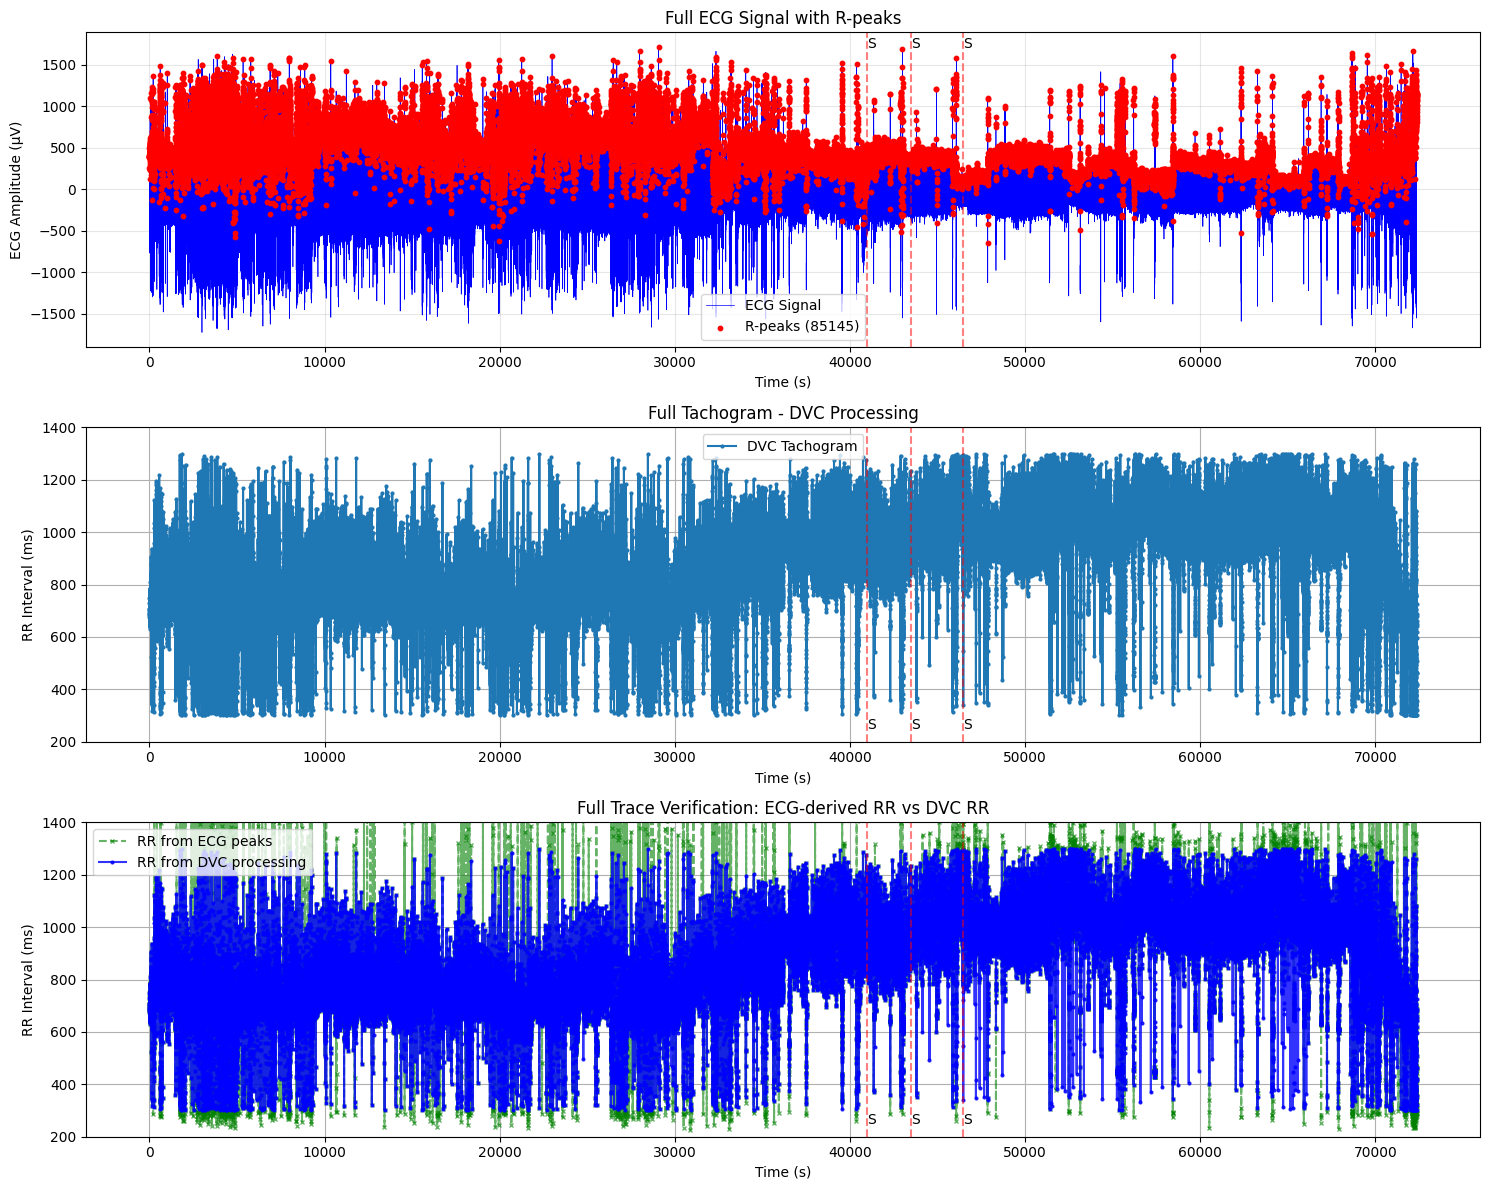


Full Trace Statistics:
  Total R-peaks in ECG: 85145
  Total RR intervals from ECG: 85144
  Total RR intervals in DVC tachogram: 85397

  ECG-derived RR intervals (full trace):
    Mean: 849.79 ms
    Std: 210.45 ms
    Min: 226.56 ms
    Max: 4011.72 ms

  DVC tachogram RR intervals (full trace):
    Mean: 845.28 ms
    Std: 186.37 ms
    Min: 300.78 ms
    Max: 1299.29 ms

  Total difference in count: -253
  Percentage of beats modified: 0.30%


In [57]:
time_axis = new_rpeak_times_s[1:]

# Get ECG data
ecg_signal = processed_data['sub-036'][0]['ecg_signal']
rpeaks = processed_data['sub-036'][0]['rpeaks']
sampling_rate = processed_data['sub-036'][0]['sampling_rate']
seizure_events = processed_data['sub-036'][0]['seizure_events']

# Calculate RR intervals directly from ECG peaks (full trace)
rr_from_ecg_samples = np.diff(rpeaks)
rr_from_ecg_ms = (rr_from_ecg_samples / sampling_rate) * 1000
rr_time_axis = (rpeaks[1:] / sampling_rate)

# Create full time axis for ECG
time_axis_ecg = np.arange(len(ecg_signal)) / sampling_rate
rpeaks_times = rpeaks / sampling_rate

# Create full trace comparison figure
plt.figure(figsize=(15, 12))

# Subplot 1: Full ECG with R-peaks
plt.subplot(311)
plt.plot(time_axis_ecg, ecg_signal * 1e6, 'b-', linewidth=0.5, label='ECG Signal')
plt.scatter(rpeaks_times, ecg_signal[rpeaks] * 1e6, color='red', s=10, zorder=5, 
            label=f'R-peaks ({len(rpeaks)})')

# Add seizure onset markers
for seizure in seizure_events:
    onset_time = seizure['onset_time']
    plt.axvline(x=onset_time, color='r', linestyle='--', alpha=0.5)
    plt.text(onset_time, plt.ylim()[1] * 0.9, 'S', rotation=0)

plt.xlabel('Time (s)')
plt.ylabel('ECG Amplitude (μV)')
plt.title('Full ECG Signal with R-peaks')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Full DVC Tachogram
plt.subplot(312)
plt.plot(time_axis, new_rr_intervals_ms, marker='o', markersize=2, linestyle='-', label='DVC Tachogram')
plt.ylim(200, 1400)

# Add seizure onset markers
for seizure in seizure_events:
    onset_time = seizure['onset_time']
    plt.axvline(x=onset_time, color='r', linestyle='--', alpha=0.5)
    plt.text(onset_time, 250, 'S', rotation=0)

plt.title("Full Tachogram - DVC Processing")
plt.xlabel("Time (s)")
plt.ylabel("RR Interval (ms)")
plt.legend()
plt.grid(True)

# Subplot 3: Full verification overlay
plt.subplot(313)
plt.plot(rr_time_axis, rr_from_ecg_ms, marker='x', markersize=3, linestyle='--', 
         color='green', label='RR from ECG peaks', alpha=0.6)
plt.plot(time_axis, new_rr_intervals_ms, marker='o', markersize=2, linestyle='-', 
         color='blue', label='RR from DVC processing', alpha=0.8)
plt.ylim(200, 1400)

# Add seizure onset markers
for seizure in seizure_events:
    onset_time = seizure['onset_time']
    plt.axvline(x=onset_time, color='r', linestyle='--', alpha=0.5)
    plt.text(onset_time, 250, 'S', rotation=0)

plt.title("Full Trace Verification: ECG-derived RR vs DVC RR")
plt.xlabel("Time (s)")
plt.ylabel("RR Interval (ms)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print full trace statistics
print(f"\nFull Trace Statistics:")
print(f"  Total R-peaks in ECG: {len(rpeaks)}")
print(f"  Total RR intervals from ECG: {len(rr_from_ecg_ms)}")
print(f"  Total RR intervals in DVC tachogram: {len(new_rr_intervals_ms)}")

print(f"\n  ECG-derived RR intervals (full trace):")
print(f"    Mean: {np.mean(rr_from_ecg_ms):.2f} ms")
print(f"    Std: {np.std(rr_from_ecg_ms):.2f} ms")
print(f"    Min: {np.min(rr_from_ecg_ms):.2f} ms")
print(f"    Max: {np.max(rr_from_ecg_ms):.2f} ms")

print(f"\n  DVC tachogram RR intervals (full trace):")
print(f"    Mean: {np.mean(new_rr_intervals_ms):.2f} ms")
print(f"    Std: {np.std(new_rr_intervals_ms):.2f} ms")
print(f"    Min: {np.min(new_rr_intervals_ms):.2f} ms")
print(f"    Max: {np.max(new_rr_intervals_ms):.2f} ms")

print(f"\n  Total difference in count: {len(rr_from_ecg_ms) - len(new_rr_intervals_ms)}")
print(f"  Percentage of beats modified: {(abs(len(rr_from_ecg_ms) - len(new_rr_intervals_ms)) / len(rr_from_ecg_ms) * 100):.2f}%")

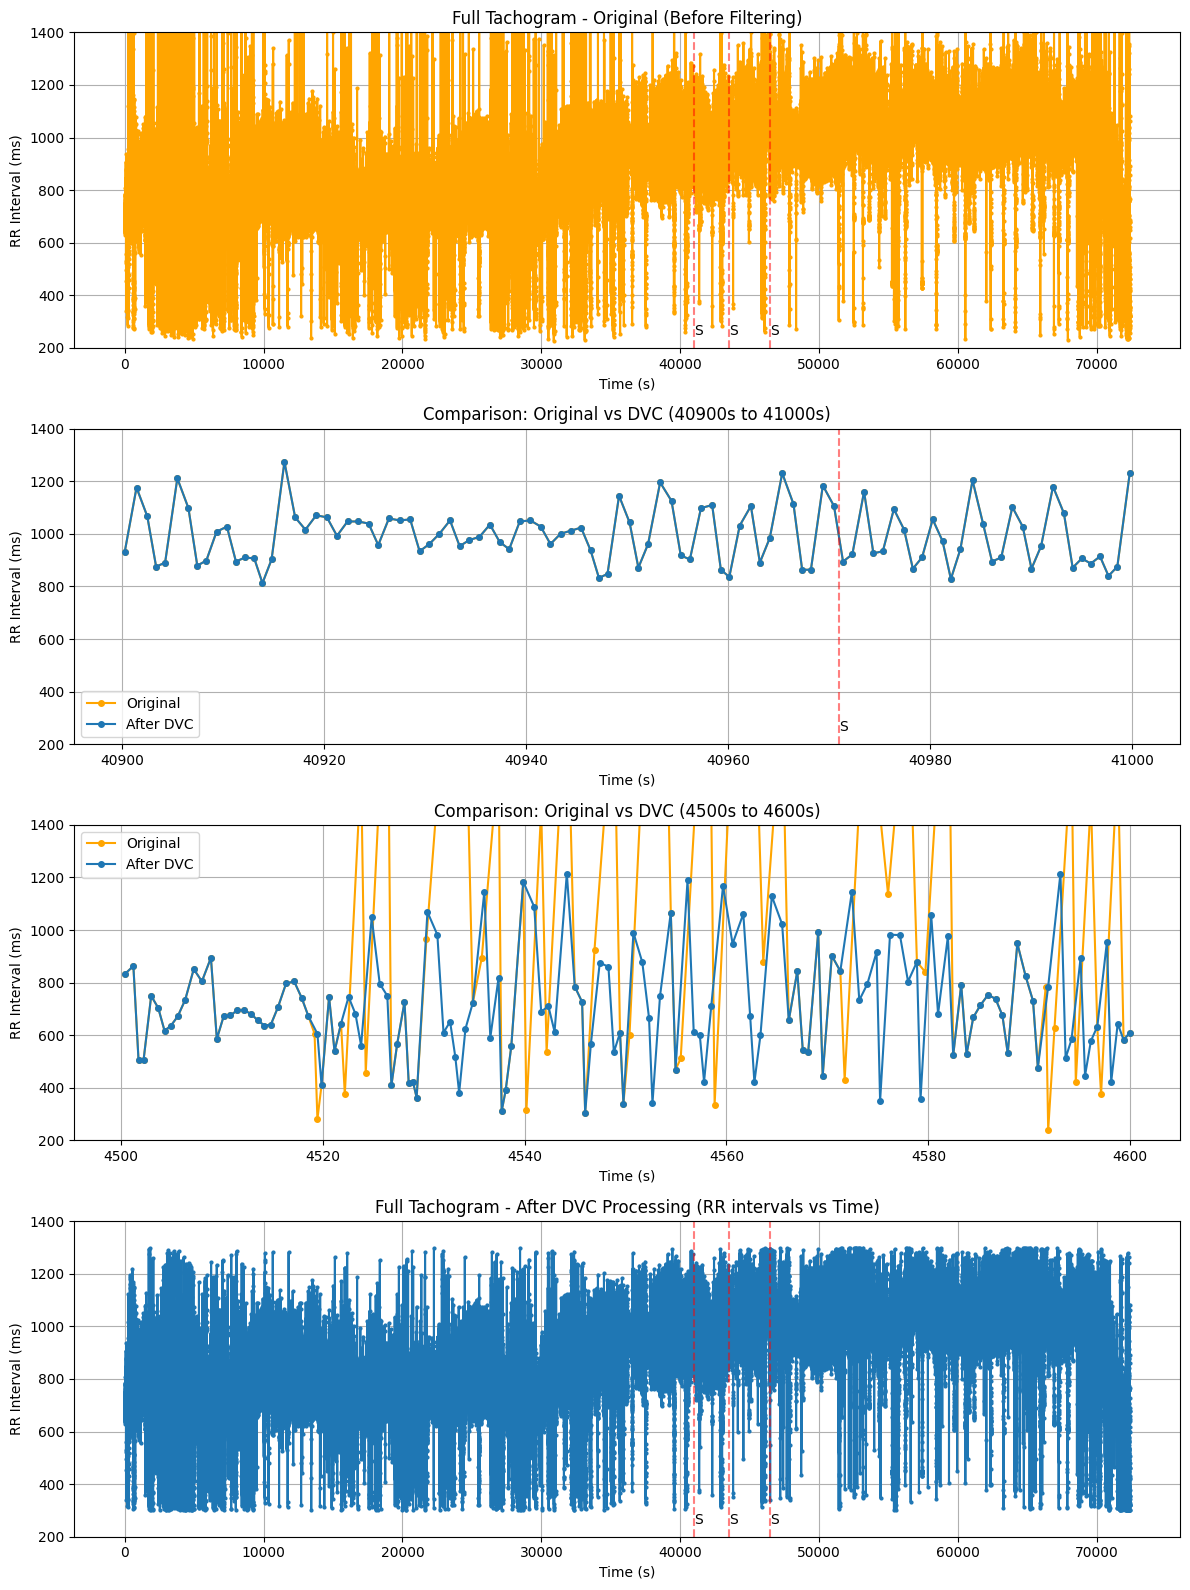

In [51]:
time_axis = new_rpeak_times_s[1:]  # Use timestamps from second peak onwards

# Get original (unfiltered) data
original_rr_intervals_ms = processed_data['sub-036'][0]['rr_intervals_ms']
original_rpeak_times_s = processed_data['sub-036'][0]['rpeaks_times']
original_time_axis = original_rpeak_times_s[1:]

# Get seizure events from processed data
seizure_events = processed_data['sub-036'][0]['seizure_events']

# Create figure with 4 subplots
plt.figure(figsize=(12, 16))

# First plot: Full tachogram with DVC-processed data
plt.subplot(414)
plt.plot(time_axis, new_rr_intervals_ms, marker='o', markersize=2, linestyle='-')
plt.ylim(200, 1400)  

# Add seizure onset markers
for seizure in seizure_events:
    onset_time = seizure['onset_time']
    plt.axvline(x=onset_time, color='r', linestyle='--', alpha=0.5)
    plt.text(onset_time, 250, 'S', rotation=0)

plt.title("Full Tachogram - After DVC Processing (RR intervals vs Time)")
plt.xlabel("Time (s)")
plt.ylabel("RR Interval (ms)")
plt.grid(True)

# Second plot: Original unfiltered data
plt.subplot(411)
plt.plot(original_time_axis, original_rr_intervals_ms, marker='o', markersize=2, linestyle='-', color='orange')
plt.ylim(200, 1400)  

# Add seizure onset markers
for seizure in seizure_events:
    onset_time = seizure['onset_time']
    plt.axvline(x=onset_time, color='r', linestyle='--', alpha=0.5)
    plt.text(onset_time, 250, 'S', rotation=0)

plt.title("Full Tachogram - Original (Before Filtering)")
plt.xlabel("Time (s)")
plt.ylabel("RR Interval (ms)")
plt.grid(True)

# Third plot: Zoomed section with start and end times
plt.subplot(412)
zoom_start = 40900  
zoom_end = 41000    
zoom_mask = (time_axis >= zoom_start) & (time_axis <= zoom_end)
original_zoom_mask = (original_time_axis >= zoom_start) & (original_time_axis <= zoom_end)

plt.plot(original_time_axis[original_zoom_mask], original_rr_intervals_ms[original_zoom_mask], 
         marker='o', markersize=4, linestyle='-', color='orange', label='Original')
plt.plot(time_axis[zoom_mask], new_rr_intervals_ms[zoom_mask], 
         marker='o', markersize=4, linestyle='-', label='After DVC')
plt.ylim(200, 1400)

# Add seizure onset markers in zoom window
for seizure in seizure_events:
    onset_time = seizure['onset_time']
    if zoom_start <= onset_time <= zoom_end:
        plt.axvline(x=onset_time, color='r', linestyle='--', alpha=0.5)
        plt.text(onset_time, 250, 'S', rotation=0)

plt.title(f"Comparison: Original vs DVC ({zoom_start}s to {zoom_end}s)")
plt.xlabel("Time (s)")
plt.ylabel("RR Interval (ms)")
plt.legend()
plt.grid(True)

# Fourth plot: Another zoomed section
plt.subplot(413)
zoom_start = 4500  
zoom_end = 4600    
zoom_mask = (time_axis >= zoom_start) & (time_axis <= zoom_end)
original_zoom_mask = (original_time_axis >= zoom_start) & (original_time_axis <= zoom_end)

plt.plot(original_time_axis[original_zoom_mask], original_rr_intervals_ms[original_zoom_mask], 
         marker='o', markersize=4, linestyle='-', color='orange', label='Original')
plt.plot(time_axis[zoom_mask], new_rr_intervals_ms[zoom_mask], 
         marker='o', markersize=4, linestyle='-', label='After DVC')
plt.ylim(200, 1400)

# Add seizure onset markers in zoom window
for seizure in seizure_events:
    onset_time = seizure['onset_time']
    if zoom_start <= onset_time <= zoom_end:
        plt.axvline(x=onset_time, color='r', linestyle='--', alpha=0.5)
        plt.text(onset_time, 250, 'S', rotation=0)

plt.title(f"Comparison: Original vs DVC ({zoom_start}s to {zoom_end}s)")
plt.xlabel("Time (s)")
plt.ylabel("RR Interval (ms)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Test 2 (other patient)

In [61]:
processed_data2 = process_all_patients_rpeaks(loader, ['sub-001'])

INFO:rpeaks_finder:Processing R-peaks detection for 1 patients: ['sub-001']
INFO:rpeaks_finder:Loading data for patient sub-001
INFO:ecg_file_loader:Processing sub-001 run 01
INFO:ecg_file_loader:Processing sub-001 run 02
INFO:ecg_file_loader:Processing sub-001 run 03
INFO:ecg_file_loader:Processing sub-001 run 04
INFO:ecg_file_loader:Processing sub-001 run 05
INFO:ecg_file_loader:Processing sub-001 run 06
INFO:ecg_file_loader:Processing sub-001 run 07
INFO:ecg_file_loader:Processing sub-001 run 08
INFO:ecg_file_loader:Processing sub-001 run 09
INFO:rpeaks_finder:Processing sub-001 run 01
INFO:rpeaks_finder:ECG signal shape: (16721664,), sampling rate: 256.0 Hz
INFO:rpeaks_finder:Successfully processed sub-001 run 01: 72450 R-peaks detected
INFO:rpeaks_finder:Processing sub-001 run 02
INFO:rpeaks_finder:ECG signal shape: (5072896,), sampling rate: 256.0 Hz
INFO:rpeaks_finder:Successfully processed sub-001 run 02: 22104 R-peaks detected
INFO:rpeaks_finder:Processing sub-001 run 03
INFO:

In [62]:
print(processed_data2)

{'sub-001': [{'patient_id': 'sub-001', 'run_number': '01', 'seizure_events': [], 'annotations':      onset  duration eventType  lateralization  localization  vigilance  \
0  14080.0      84.0      impd             NaN           NaN        NaN   
1  23838.0       8.0      impd             NaN           NaN        NaN   

   confidence  channels             dateTime  recordingDuration  
0         NaN       NaN  2000-01-01 00:00:00            65319.0  
1         NaN       NaN  2000-01-01 00:00:00            65319.0  , 'ecg_signal': array([ 9.01747158e-06, -1.29744411e-05, -1.39778744e-05, ...,
        2.83817807e-08,  2.83817807e-08,  2.83817807e-08],
      shape=(16721664,)), 'sampling_rate': 256.0, 'duration_seconds': 65319.0, 'rpeaks': array([       9,      220,      432, ..., 16720440, 16720662, 16720877],
      shape=(72450,)), 'rpeaks_times': array([3.51562500e-02, 8.59375000e-01, 1.68750000e+00, ...,
       6.53142188e+04, 6.53150859e+04, 6.53159258e+04], shape=(72450,)), 'rr_inter

In [63]:
len(processed_data2['sub-001'][0]['rr_intervals_ms']), len(processed_data2['sub-001'][0]['rpeaks_times'])

(72449, 72450)

In [66]:
processed_rr2 = process_dvc_for_session(processed_data2['sub-001'][0], min_rr_s=0.3, max_rr_s=1.3)


--------------------------------------------------
Processing session 01 for patient sub-001
--------------------------------------------------
Initial state: 72449 RRs, 72450 timestamps.
--- Starting Ectopic Beat Filtering ---
Found 57 RR intervals > 1.3s. Deleting them to create gaps.
Found short RR interval (0.289s) at index 49661. Analyzing merge options...
  > No merge met all conditions. Deleting the single short RR interval as an artifact.
Found short RR interval (0.293s) at index 31502. Analyzing merge options...
  > Right merge successful. New RR: 0.648s.
Found short RR interval (0.273s) at index 31486. Analyzing merge options...
  > No merge met all conditions. Deleting the single short RR interval as an artifact.
Found short RR interval (0.270s) at index 16261. Analyzing merge options...
  > Right merge successful. New RR: 1.078s.
Found short RR interval (0.289s) at index 16227. Analyzing merge options...
  > No merge met all conditions. Deleting the single short RR interva

In [68]:
new_rr_intervals_ms2 = processed_rr2['dvc_rr_intervals_ms']
new_rpeak_times_s2 = processed_rr2['dvc_rpeak_times_s']
len(new_rr_intervals_ms2), len(new_rpeak_times_s2)  # Should be len(new_rpeak_times_s2) == len(new_rr_intervals_ms2) + 1

(72509, 72510)

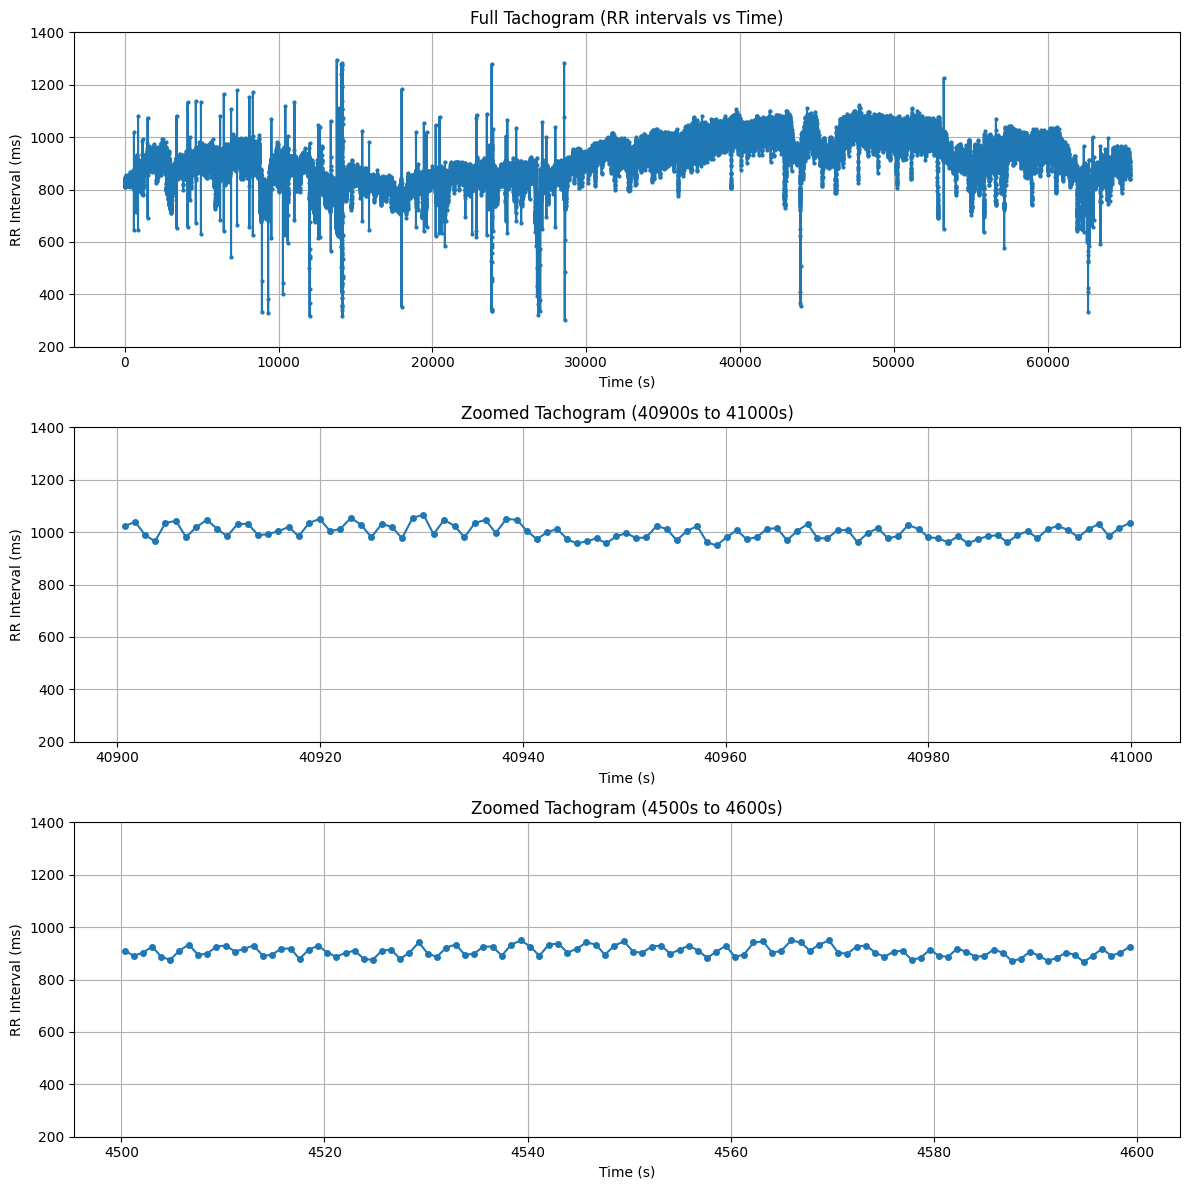

In [70]:
time_axis = new_rpeak_times_s2[1:]  # Use timestamps from second peak onwards

# Get seizure events from processed data
seizure_events = processed_data2['sub-001'][0]['seizure_events']

# First plot: Full tachogram with fixed y-axis limits and seizure markers
plt.figure(figsize=(12, 12))
plt.subplot(311)
plt.plot(time_axis, new_rr_intervals_ms2, marker='o', markersize=2, linestyle='-')
plt.ylim(200, 1400)  

# Add seizure onset markers 
for seizure in seizure_events:
    onset_time = seizure['onset_time']
    plt.axvline(x=onset_time, color='r', linestyle='--', alpha=0.5)
    plt.text(onset_time, 250, 'S', rotation=0)

plt.title("Full Tachogram (RR intervals vs Time)")
plt.xlabel("Time (s)")
plt.ylabel("RR Interval (ms)")
plt.grid(True)

# Second plot: Zoomed section with start and end times
plt.subplot(312)
zoom_start = 40900  
zoom_end = 41000    
zoom_mask = (time_axis >= zoom_start) & (time_axis <= zoom_end)
plt.plot(time_axis[zoom_mask], new_rr_intervals_ms2[zoom_mask], 
         marker='o', markersize=4, linestyle='-')
plt.ylim(200, 1400)

# Add seizure onset markers in zoom window
for seizure in seizure_events:
    onset_time = seizure['onset_time']
    if zoom_start <= onset_time <= zoom_end:
        plt.axvline(x=onset_time, color='r', linestyle='--', alpha=0.5)
        plt.text(onset_time, 250, 'S', rotation=0)

plt.title(f"Zoomed Tachogram ({zoom_start}s to {zoom_end}s)")
plt.xlabel("Time (s)")
plt.ylabel("RR Interval (ms)")
plt.grid(True)

# Third plot: Zoomed section with start and end times
plt.subplot(313)
zoom_start = 4500  
zoom_end = 4600    
zoom_mask = (time_axis >= zoom_start) & (time_axis <= zoom_end)
plt.plot(time_axis[zoom_mask], new_rr_intervals_ms2[zoom_mask], 
         marker='o', markersize=4, linestyle='-')
plt.ylim(200, 1400)

# Add seizure onset markers in zoom window
for seizure in seizure_events:
    onset_time = seizure['onset_time']
    if zoom_start <= onset_time <= zoom_end:
        plt.axvline(x=onset_time, color='r', linestyle='--', alpha=0.5)
        plt.text(onset_time, 250, 'S', rotation=0)

plt.title(f"Zoomed Tachogram ({zoom_start}s to {zoom_end}s)")
plt.xlabel("Time (s)")
plt.ylabel("RR Interval (ms)")
plt.grid(True)

plt.tight_layout()
plt.show()

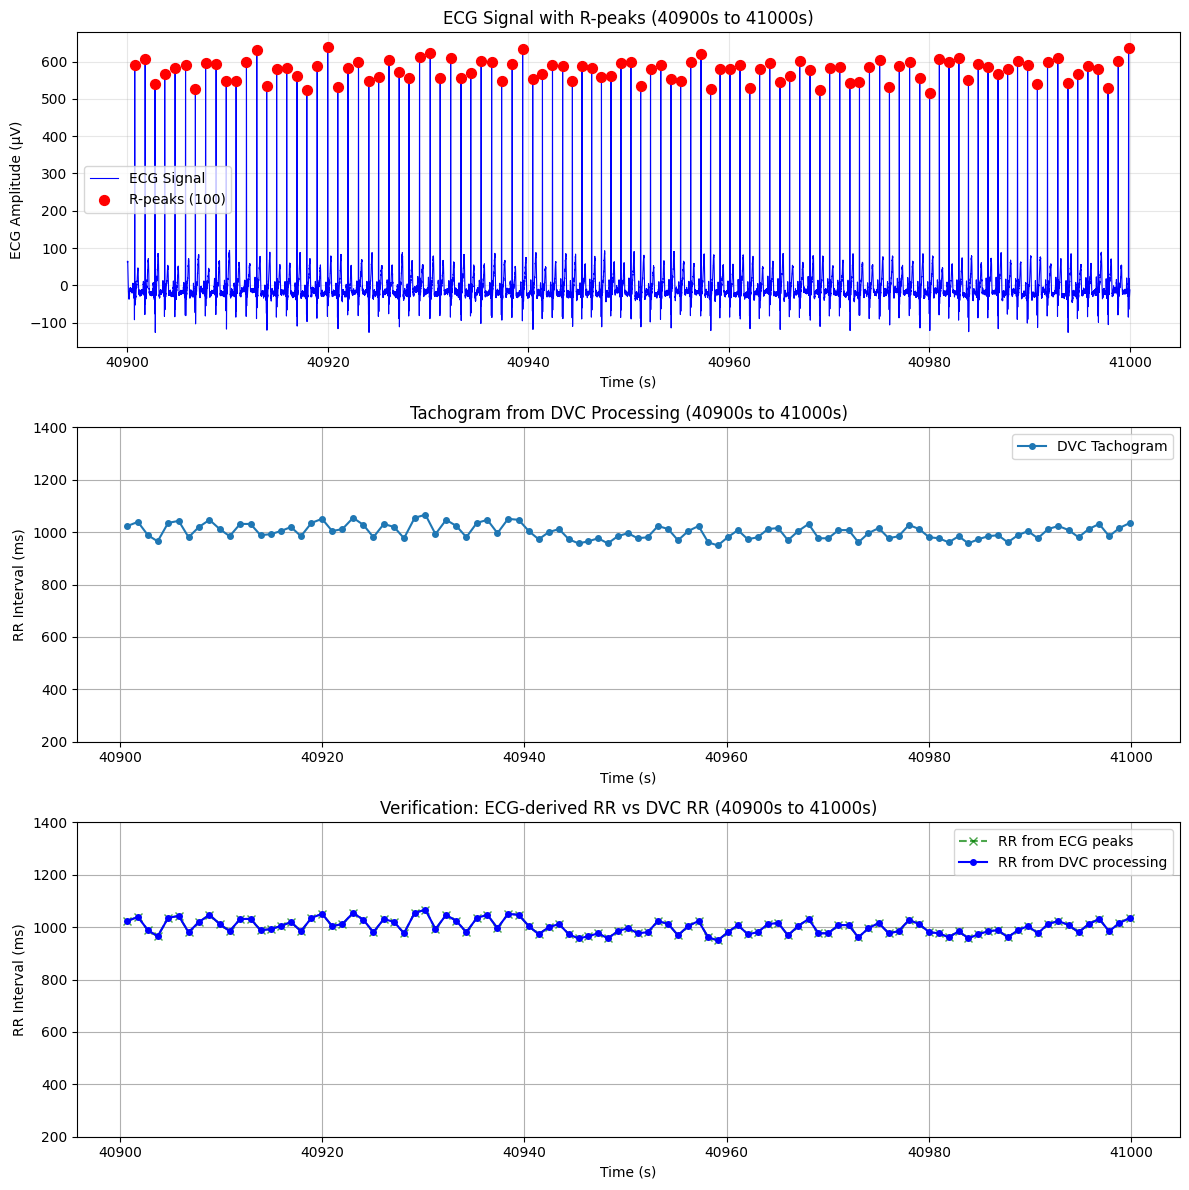


Verification Statistics for window 40900s to 41000s:
  Number of R-peaks in ECG: 100
  Number of RR intervals from ECG: 100
  Number of RR intervals in DVC tachogram: 100

  ECG-derived RR intervals:
    Mean: 1001.64 ms
    Std: 27.63 ms

  DVC tachogram RR intervals:
    Mean: 1001.64 ms
    Std: 27.63 ms

  Difference in count: 0


In [71]:
# Verification: Compare RR intervals from different sources
time_axis = new_rpeak_times_s2[1:]

# Get ECG data
ecg_signal = processed_data2['sub-001'][0]['ecg_signal']
rpeaks = processed_data2['sub-001'][0]['rpeaks']
sampling_rate = processed_data2['sub-001'][0]['sampling_rate']
seizure_events = processed_data2['sub-001'][0]['seizure_events']

# Define zoom window
zoom_start = 40900  
zoom_end = 41000

# Calculate RR intervals directly from ECG peaks (in samples)
rr_from_ecg_samples = np.diff(rpeaks)
rr_from_ecg_ms = (rr_from_ecg_samples / sampling_rate) * 1000  # Convert to ms
rr_time_axis = (rpeaks[1:] / sampling_rate)  # Time axis for ECG-based RR

# Create comparison figure
plt.figure(figsize=(12, 12))

# Subplot 1: ECG Signal with R-peaks
plt.subplot(311)
start_sample = int(zoom_start * sampling_rate)
end_sample = int(zoom_end * sampling_rate)
time_axis_ecg = np.arange(start_sample, end_sample) / sampling_rate
ecg_segment = ecg_signal[start_sample:end_sample]
rpeaks_in_window = rpeaks[(rpeaks >= start_sample) & (rpeaks < end_sample)]
rpeaks_times = rpeaks_in_window / sampling_rate

plt.plot(time_axis_ecg, ecg_segment * 1e6, 'b-', linewidth=0.8, label='ECG Signal')
if len(rpeaks_in_window) > 0:
    rpeak_values = ecg_signal[rpeaks_in_window] * 1e6
    plt.scatter(rpeaks_times, rpeak_values, color='red', s=50, zorder=5, 
                label=f'R-peaks ({len(rpeaks_in_window)})')
plt.xlabel('Time (s)')
plt.ylabel('ECG Amplitude (μV)')
plt.title(f'ECG Signal with R-peaks ({zoom_start}s to {zoom_end}s)')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Tachogram from DVC processing
plt.subplot(312)
zoom_mask = (time_axis >= zoom_start) & (time_axis <= zoom_end)
plt.plot(time_axis[zoom_mask], new_rr_intervals_ms2[zoom_mask], 
         marker='o', markersize=4, linestyle='-', label='DVC Tachogram')
plt.ylim(200, 1400)
plt.title(f"Tachogram from DVC Processing ({zoom_start}s to {zoom_end}s)")
plt.xlabel("Time (s)")
plt.ylabel("RR Interval (ms)")
plt.legend()
plt.grid(True)

# Subplot 3: Overlay comparison - RR from ECG vs DVC Tachogram
plt.subplot(313)
rr_ecg_mask = (rr_time_axis >= zoom_start) & (rr_time_axis <= zoom_end)
plt.plot(rr_time_axis[rr_ecg_mask], rr_from_ecg_ms[rr_ecg_mask], 
         marker='x', markersize=6, linestyle='--', color='green', 
         label='RR from ECG peaks', alpha=0.7)
plt.plot(time_axis[zoom_mask], new_rr_intervals_ms2[zoom_mask], 
         marker='o', markersize=4, linestyle='-', color='blue',
         label='RR from DVC processing')
plt.ylim(200, 1400)
plt.title(f"Verification: ECG-derived RR vs DVC RR ({zoom_start}s to {zoom_end}s)")
plt.xlabel("Time (s)")
plt.ylabel("RR Interval (ms)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print numerical comparison
print(f"\nVerification Statistics for window {zoom_start}s to {zoom_end}s:")
print(f"  Number of R-peaks in ECG: {len(rpeaks_in_window)}")
print(f"  Number of RR intervals from ECG: {len(rr_from_ecg_ms[rr_ecg_mask])}")
print(f"  Number of RR intervals in DVC tachogram: {len(new_rr_intervals_ms2[zoom_mask])}")

if len(rr_from_ecg_ms[rr_ecg_mask]) > 0:
    print(f"\n  ECG-derived RR intervals:")
    print(f"    Mean: {np.mean(rr_from_ecg_ms[rr_ecg_mask]):.2f} ms")
    print(f"    Std: {np.std(rr_from_ecg_ms[rr_ecg_mask]):.2f} ms")
    
if len(new_rr_intervals_ms2[zoom_mask]) > 0:
    print(f"\n  DVC tachogram RR intervals:")
    print(f"    Mean: {np.mean(new_rr_intervals_ms2[zoom_mask]):.2f} ms")
    print(f"    Std: {np.std(new_rr_intervals_ms2[zoom_mask]):.2f} ms")

# Check for differences
print(f"\n  Difference in count: {len(rr_from_ecg_ms[rr_ecg_mask]) - len(new_rr_intervals_ms2[zoom_mask])}")

/var/folders/t9/y0kz8xdd095bf5z18bbw4y540000gn/T/ipykernel_54017/2328897363.py:76: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


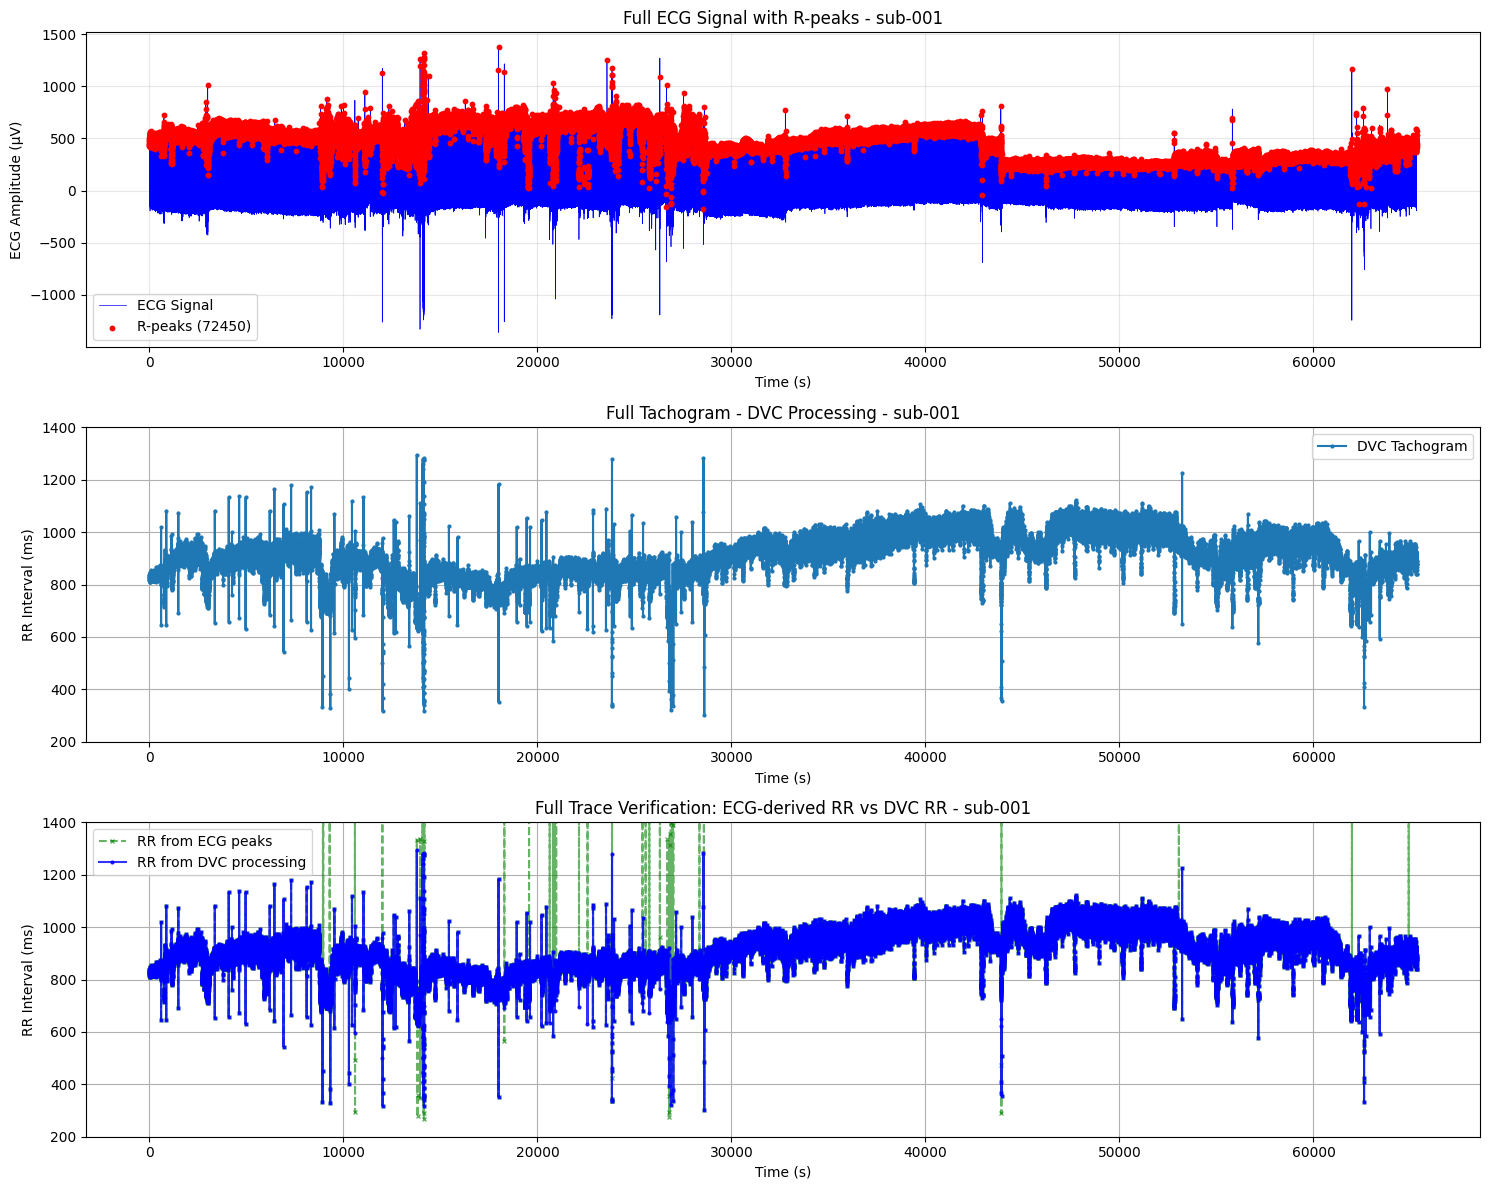


Full Trace Statistics - sub-001:
  Total R-peaks in ECG: 72450
  Total RR intervals from ECG: 72449
  Total RR intervals in DVC tachogram: 72509

  ECG-derived RR intervals (full trace):
    Mean: 901.54 ms
    Std: 86.92 ms
    Min: 269.53 ms
    Max: 2527.34 ms

  DVC tachogram RR intervals (full trace):
    Mean: 900.76 ms
    Std: 83.21 ms
    Min: 300.78 ms
    Max: 1295.10 ms

  Total difference in count: -60
  Percentage of beats modified: 0.08%


In [75]:
time_axis = new_rpeak_times_s2[1:]

# Get ECG data
ecg_signal = processed_data2['sub-001'][0]['ecg_signal']
rpeaks = processed_data2['sub-001'][0]['rpeaks']
sampling_rate = processed_data2['sub-001'][0]['sampling_rate']
seizure_events = processed_data2['sub-001'][0]['seizure_events']

# Calculate RR intervals directly from ECG peaks (full trace)
rr_from_ecg_samples = np.diff(rpeaks)
rr_from_ecg_ms = (rr_from_ecg_samples / sampling_rate) * 1000
rr_time_axis = (rpeaks[1:] / sampling_rate)

# Create full time axis for ECG
time_axis_ecg = np.arange(len(ecg_signal)) / sampling_rate
rpeaks_times = rpeaks / sampling_rate

# Create full trace comparison figure
plt.figure(figsize=(15, 12))

# Subplot 1: Full ECG with R-peaks
plt.subplot(311)
plt.plot(time_axis_ecg, ecg_signal * 1e6, 'b-', linewidth=0.5, label='ECG Signal')
plt.scatter(rpeaks_times, ecg_signal[rpeaks] * 1e6, color='red', s=10, zorder=5, 
            label=f'R-peaks ({len(rpeaks)})')

# Add seizure onset markers
for seizure in seizure_events:
    onset_time = seizure['onset_time']
    plt.axvline(x=onset_time, color='r', linestyle='--', alpha=0.5)
    plt.text(onset_time, plt.ylim()[1] * 0.9, 'S', rotation=0)

plt.xlabel('Time (s)')
plt.ylabel('ECG Amplitude (μV)')
plt.title('Full ECG Signal with R-peaks - sub-001')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Full DVC Tachogram
plt.subplot(312)
plt.plot(time_axis, new_rr_intervals_ms2, marker='o', markersize=2, linestyle='-', label='DVC Tachogram')
plt.ylim(200, 1400)

# Add seizure onset markers
for seizure in seizure_events:
    onset_time = seizure['onset_time']
    plt.axvline(x=onset_time, color='r', linestyle='--', alpha=0.5)
    plt.text(onset_time, 250, 'S', rotation=0)

plt.title("Full Tachogram - DVC Processing - sub-001")
plt.xlabel("Time (s)")
plt.ylabel("RR Interval (ms)")
plt.legend()
plt.grid(True)

# Subplot 3: Full verification overlay
plt.subplot(313)
plt.plot(rr_time_axis, rr_from_ecg_ms, marker='x', markersize=3, linestyle='--', 
         color='green', label='RR from ECG peaks', alpha=0.6)
plt.plot(time_axis, new_rr_intervals_ms2, marker='o', markersize=2, linestyle='-', 
         color='blue', label='RR from DVC processing', alpha=0.8)
plt.ylim(200, 1400)

# Add seizure onset markers
for seizure in seizure_events:
    onset_time = seizure['onset_time']
    plt.axvline(x=onset_time, color='r', linestyle='--', alpha=0.5)
    plt.text(onset_time, 250, 'S', rotation=0)

plt.title("Full Trace Verification: ECG-derived RR vs DVC RR - sub-001")
plt.xlabel("Time (s)")
plt.ylabel("RR Interval (ms)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print full trace statistics
print(f"\nFull Trace Statistics - sub-001:")
print(f"  Total R-peaks in ECG: {len(rpeaks)}")
print(f"  Total RR intervals from ECG: {len(rr_from_ecg_ms)}")
print(f"  Total RR intervals in DVC tachogram: {len(new_rr_intervals_ms2)}")

print(f"\n  ECG-derived RR intervals (full trace):")
print(f"    Mean: {np.mean(rr_from_ecg_ms):.2f} ms")
print(f"    Std: {np.std(rr_from_ecg_ms):.2f} ms")
print(f"    Min: {np.min(rr_from_ecg_ms):.2f} ms")
print(f"    Max: {np.max(rr_from_ecg_ms):.2f} ms")

print(f"\n  DVC tachogram RR intervals (full trace):")
print(f"    Mean: {np.mean(new_rr_intervals_ms2):.2f} ms")
print(f"    Std: {np.std(new_rr_intervals_ms2):.2f} ms")
print(f"    Min: {np.min(new_rr_intervals_ms2):.2f} ms")
print(f"    Max: {np.max(new_rr_intervals_ms2):.2f} ms")

print(f"\n  Total difference in count: {len(rr_from_ecg_ms) - len(new_rr_intervals_ms2)}")
print(f"  Percentage of beats modified: {(abs(len(rr_from_ecg_ms) - len(new_rr_intervals_ms2)) / len(rr_from_ecg_ms) * 100):.2f}%")